# 1. Implementing your own Shazam


In [ ]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [ ]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    
    

## Settings

In [ ]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30
THRESHOLD = 0

In [ ]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [ ]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

## Audio signals

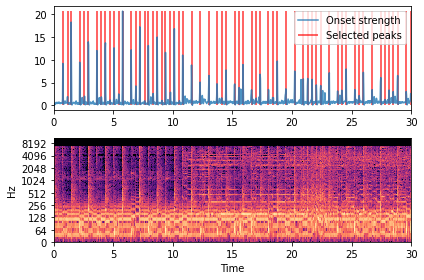

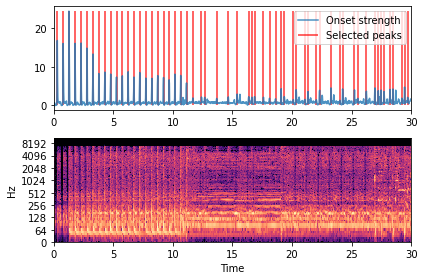

In [ ]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)
        
        

## 1.2 Fingerprint hashing

In [ ]:
import random
import numpy as np
import pandas as pd

Functions

In [ ]:
def gen_coefficient(num, upper_bound):
    coeff = []
    for i in range(0, num):
        rand_value = random.randint(0, upper_bound) 
        coeff.append(rand_value)
    return coeff

In [ ]:
#hashing function
def hash(a, b, x, w):
    return (a * x + b) % w

In [ ]:
UPPERBOUND = 2**32-1
TOTAL = 8
#first prime after upperbound
PRIME = 4294967311

#generate coeff lists A,B
coeff_A = gen_coefficient(TOTAL, UPPERBOUND)
coeff_B = gen_coefficient(TOTAL, UPPERBOUND)

In [ ]:
#generate audio signature
def gen_audio_signature(audio):
    signature = []
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)

    for i in range(0, TOTAL) :
        hash_list = []
        for x in peaks:
            hash_value = hash(x, coeff_A[i], coeff_B[i], PRIME)
            hash_list.append(hash_value)

        #print(hash_list)        
        signature.append(min(hash_list))

    return signature

### TRACK SIGNATURE

In [ ]:
from joblib import Parallel, delayed

tracks_signature = []
data_folder = Path("data/mp3s-32k/")
tracks = data_folder.glob("*/*/*.wav")

def signature(audio, idx):
    audio_signature = gen_audio_signature(audio)
    return (idx, audio, audio_signature)

tracks_signature = Parallel(n_jobs=-1)(delayed(signature)(audio, idx) for idx, audio in tqdm(enumerate(tracks), total=N_TRACKS))


  0%|          | 0/1413 [00:00<?, ?it/s]

In [ ]:
#save track signature to csv file
tracks_signature_df = pd.DataFrame(tracks_signature, columns=['idx', 'path', 'signature'])
tracks_signature_df.to_csv('tracks_signature.csv')

In [ ]:
#load track signature
tracks_signature_ = pd.read_csv('tracks_signature.csv')

### QUERY SIGNATURE

In [ ]:
#get query files path
query_tracks_ = Path("query/").glob("*.wav")

query_signature = []

for idx, audio in enumerate(query_tracks_):
    audio_signature = gen_audio_signature(audio)
    query_signature.append((idx, audio, audio_signature))
#print(query_signature)

In [ ]:
#save query signature to csv file
query_signature_df = pd.DataFrame(query_signature, columns=['idx', 'path', 'signature'])
query_signature_df.to_csv('query_signature.csv')

In [ ]:
#load track signature
query_signature_ = pd.read_csv('query_signature.csv')

### MATCHING

In [ ]:
# Jaccard Similarity function
def jaccard(A, B):
    return len(A.intersection(B))/len(A.union(B))

In [ ]:
hash_sign = []

def audio_match(threshold):
    for i, row_q in query_signature_.iterrows():
        for j, row_t in tracks_signature_.iterrows():

            track_hash_sign = list(map(int, row_t['signature'].strip('][').split(', ')))
            query_hash_sign = list(map(int, row_q['signature'].strip('][').split(', ')))

            idx = int(row_t.idx)
            track_path = row_t.path
            track_artist = track_path.split('/')[2].replace('_', ' ')
            track_album = track_path.split('/')[3].replace('_', ' ')
            track_title = track_path.split('/')[-1].split('-')[-1].replace('.wav', '').replace('_', ' ')

            query_path = row_q.path
            query_title = query_path.split('/')[-1]


            jaccard_sim = jaccard(set(query_hash_sign), set(track_hash_sign) )

            if jaccard_sim >= threshold:
                print("Query:", str(query_title))
                print("Matched with:", track_path)
                print("Title:", track_title)
                print("Album:", track_album)
                print("Artist:", track_artist)
                print("Similarity score:", jaccard_sim)
                print()

In [ ]:
audio_match(1.0)

Query: track8.wav
Matched with: data/mp3s-32k/green_day/American_Idiot/01-American_Idiot.wav
Title: American Idiot
Album: American Idiot
Artist: green day
Similarity score: 1.0

Query: track9.wav
Matched with: data/mp3s-32k/depeche_mode/Some_Great_Reward/06-Somebody.wav
Title: Somebody
Album: Some Great Reward
Artist: depeche mode
Similarity score: 1.0

Query: track10.wav
Matched with: data/mp3s-32k/steely_dan/Katy_Lied/01-Black_Friday.wav
Title: Black Friday
Album: Katy Lied
Artist: steely dan
Similarity score: 1.0

Query: track2.wav
Matched with: data/mp3s-32k/queen/The_Works/06-I_Want_To_Break_Free.wav
Title: I Want To Break Free
Album: The Works
Artist: queen
Similarity score: 1.0

Query: track3.wav
Matched with: data/mp3s-32k/u2/October/07-October.wav
Title: October
Album: October
Artist: u2
Similarity score: 1.0

Query: track1.wav
Matched with: data/mp3s-32k/aerosmith/Aerosmith/03-Dream_On.wav
Title: Dream On
Album: Aerosmith
Artist: aerosmith
Similarity score: 1.0

Query: track4

In [ ]:
audio_match(0.2)

Query: track8.wav
Matched with: data/mp3s-32k/led_zeppelin/Led_Zeppelin_II/07-Ramble_On.wav
Title: Ramble On
Album: Led Zeppelin II
Artist: led zeppelin
Similarity score: 0.23076923076923078

Query: track8.wav
Matched with: data/mp3s-32k/green_day/American_Idiot/01-American_Idiot.wav
Title: American Idiot
Album: American Idiot
Artist: green day
Similarity score: 1.0

Query: track9.wav
Matched with: data/mp3s-32k/depeche_mode/Some_Great_Reward/06-Somebody.wav
Title: Somebody
Album: Some Great Reward
Artist: depeche mode
Similarity score: 1.0

Query: track10.wav
Matched with: data/mp3s-32k/metallica/Metallica/07-Through_the_Never.wav
Title: Through the Never
Album: Metallica
Artist: metallica
Similarity score: 0.23076923076923078

Query: track10.wav
Matched with: data/mp3s-32k/steely_dan/Katy_Lied/01-Black_Friday.wav
Title: Black Friday
Album: Katy Lied
Artist: steely dan
Similarity score: 1.0

Query: track10.wav
Matched with: data/mp3s-32k/cure/Wild_Mood_Swings/13-Treasure.wav
Title: Tr

In [ ]:
audio_match(0.1)

Query: track8.wav
Matched with: data/mp3s-32k/led_zeppelin/Led_Zeppelin_II/07-Ramble_On.wav
Title: Ramble On
Album: Led Zeppelin II
Artist: led zeppelin
Similarity score: 0.23076923076923078

Query: track8.wav
Matched with: data/mp3s-32k/roxette/Look_Sharp_/10-View_From_A_Hill.wav
Title: View From A Hill
Album: Look Sharp 
Artist: roxette
Similarity score: 0.14285714285714285

Query: track8.wav
Matched with: data/mp3s-32k/roxette/Pearls_of_Passion_1997_Remaster_/13-Pearls_Of_Passion.wav
Title: Pearls Of Passion
Album: Pearls of Passion 1997 Remaster 
Artist: roxette
Similarity score: 0.14285714285714285

Query: track8.wav
Matched with: data/mp3s-32k/steely_dan/Katy_Lied/10-Throw_Back_The_Little_Ones.wav
Title: Throw Back The Little Ones
Album: Katy Lied
Artist: steely dan
Similarity score: 0.14285714285714285

Query: track8.wav
Matched with: data/mp3s-32k/steely_dan/The_Royal_Scam/09-The_Royal_Scam.wav
Title: The Royal Scam
Album: The Royal Scam
Artist: steely dan
Similarity score: 0.1

# 2. Grouping songs together!

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import kmeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.datasets import make_blobs

## 2.1 Getting your data!

In [2]:
echonest = pd.read_csv('csv/echonest.csv')
features = pd.read_csv('csv/features.csv')
tracks = pd.read_csv('csv/tracks.csv')

In [3]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


In [5]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

In [12]:
set_echonest = set(echonest.track_id.to_list())
set_features = set(features.track_id.to_list())
set_tracks = set(tracks.track_id.to_list())
echo_feat = set_echonest.issubset(set_features)
echo_trac = set_echonest.issubset(set_tracks)
print(echo_feat)
print(echo_trac)

True
True


In [13]:
#merge
new_df = pd.merge(echonest, features, on='track_id', how='inner')
main_df = pd.merge(new_df, tracks, on='track_id', how='inner')

In [14]:
#519 + 250 + 53 - 2 (track_id duplicates) = 820 columns
main_df.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music


In [15]:
# main_df.to_csv('csv/main_df.csv', index=False)

In [16]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to track_title
dtypes: float64(764), int64(16), object(40)
memory usage: 82.2+ MB


## 2.2 Choose your features (variables)!

In [3]:
echo_cp = echonest.copy()
feat_cp = features.copy()
tracks_cp = tracks.copy()

### PCA on Echonest

In [4]:
# we want to use the PCA only on the temporal columns, so we need to take them
col_temp = [x for x in echo_cp if x.startswith('temporal')]
other_col = [x for x in echo_cp.columns.to_list() if x not in col_temp]
echo_PCA = echo_cp.loc[:, col_temp]

In [6]:
# Standardize the Data
scaler = StandardScaler()
echo_PCA = scaler.fit_transform(echo_PCA)

In [7]:
# Apply PCA
pca = PCA(0.90)
pc_echo = pca.fit_transform(echo_PCA)
pca_num = len(pca.components_)

#### Final Echonest dataset

In [8]:
pc_echo_df = pd.DataFrame(data=pc_echo, columns=['pc_echo_'+str(i) for i in range(pca_num)])
echo_final = pd.concat([echo_cp[other_col], pc_echo_df], axis=1)
echo_final

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,pc_echo_61,pc_echo_62,pc_echo_63,pc_echo_64,pc_echo_65,pc_echo_66,pc_echo_67,pc_echo_68,pc_echo_69,pc_echo_70
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,0.355263,0.027481,-0.157763,-0.402039,0.616848,0.214498,-0.590703,-0.054720,-0.578055,-0.663876
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,0.646931,-0.710005,0.117975,0.629340,0.497755,0.480609,-0.119040,-1.234916,-1.123355,0.611513
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,1.335908,-0.759942,-1.022644,0.702416,-0.007906,-0.073801,0.047319,-0.523209,-0.601322,0.187780
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-0.612253,0.669184,-0.822872,0.816882,-2.254254,0.742618,0.557756,-0.347822,1.052869,0.056952
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,0.632782,-0.020439,-0.015756,0.016399,0.546659,-0.994958,-0.266806,0.271617,-0.214411,-0.335870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,-0.050183,-0.170786,0.525707,-0.209289,0.796353,-0.220514,0.137357,-0.066496,0.041413,-0.323454
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,1.044994,-0.029680,0.990371,0.127782,0.057740,0.865349,0.514955,-0.238700,0.156817,1.179561
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,0.975914,-0.710217,0.703303,-0.660872,-0.240822,-0.325763,-0.718858,0.518075,-0.084971,0.104979
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,-0.236248,-0.152645,-0.093776,0.536602,-0.039933,-0.331019,0.247020,-0.356199,0.515033,0.661125


In [9]:
print(f"With the PCA, we had a reduction of the temporal columns of echonest dataset from {len(col_temp)} to {pca_num}")

With the PCA, we had a reduction of the temporal columns of echonest dataset from 224 to 71


In [10]:
echo_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 97 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   track_id                            13129 non-null  int64  
 1   audio_features_acousticness         13129 non-null  float64
 2   audio_features_danceability         13129 non-null  float64
 3   audio_features_energy               13129 non-null  float64
 4   audio_features_instrumentalness     13129 non-null  float64
 5   audio_features_liveness             13129 non-null  float64
 6   audio_features_speechiness          13129 non-null  float64
 7   audio_features_tempo                13129 non-null  float64
 8   audio_features_valence              13129 non-null  float64
 9   metadata_album_date                 2717 non-null   object 
 10  metadata_album_name                 2872 non-null   object 
 11  metadata_artist_latitude            9770 

### PCA on Features

The features dataset has so many columns, and since some of them have a string on their name in common, we are going to apply the PCA separately.

In [11]:
col_temp_chroma = [x for x in feat_cp if x.startswith('chroma')]
col_temp_mfcc = [x for x in feat_cp if x.startswith('mfcc')]
col_temp_rmse = [x for x in feat_cp if x.startswith('rmse')]
col_temp_spectral = [x for x in feat_cp if x.startswith('spectral')]
col_temp_tonnetz = [x for x in feat_cp if x.startswith('tonnetz')]
col_temp_zcr = [x for x in feat_cp if x.startswith('zcr')]
col_temp = col_temp_chroma + col_temp_mfcc + col_temp_rmse + col_temp_spectral + col_temp_tonnetz + col_temp_zcr
other_col = [x for x in feat_cp.columns.to_list() if x not in col_temp]

In [12]:
# chroma column
feat_PCA_chroma = feat_cp.loc[:, col_temp_chroma]
scaler1 = StandardScaler()
feat_PCA_chroma = scaler1.fit_transform(feat_PCA_chroma)

# mfcc column
feat_PCA_mfcc = feat_cp.loc[:, col_temp_mfcc]
scaler2 = StandardScaler()
feat_PCA_mfcc = scaler2.fit_transform(feat_PCA_mfcc)

# rmse column
feat_PCA_rmse = feat_cp.loc[:, col_temp_rmse]
scaler3 = StandardScaler()
feat_PCA_rmse = scaler3.fit_transform(feat_PCA_rmse)

# spectral column
feat_PCA_spectral = feat_cp.loc[:, col_temp_spectral]
scaler4 = StandardScaler()
feat_PCA_spectral = scaler4.fit_transform(feat_PCA_spectral)

# tonnetz column
feat_PCA_tonnetz = feat_cp.loc[:, col_temp_tonnetz]
scaler5 = StandardScaler()
feat_PCA_tonnetz = scaler5.fit_transform(feat_PCA_tonnetz)

# zcr column
feat_PCA_zcr = feat_cp.loc[:, col_temp_zcr]
scaler6 = StandardScaler()
feat_PCA_zcr = scaler6.fit_transform(feat_PCA_zcr)

In [14]:
# chroma column
pca1 = PCA(0.90)
pc_feat_chroma = pca1.fit_transform(feat_PCA_chroma)
pca_num_chroma = len(pca1.components_)

# mfcc column
pca2 = PCA(0.90)
pc_feat_mfcc = pca2.fit_transform(feat_PCA_mfcc)
pca_num_mfcc = len(pca2.components_)

# rmse column
pca3 = PCA(0.90)
pc_feat_rmse = pca3.fit_transform(feat_PCA_rmse)
pca_num_rmse = len(pca3.components_)

# spectral column
pca4 = PCA(0.90)
pc_feat_spectral = pca4.fit_transform(feat_PCA_spectral)
pca_num_spectral = len(pca4.components_)

# tonnetz column
pca5 = PCA(0.90)
pc_feat_tonnetz = pca5.fit_transform(feat_PCA_tonnetz)
pca_num_tonnetz = len(pca5.components_)

# zcr column
pca6 = PCA(0.90)
pc_feat_zcr = pca6.fit_transform(feat_PCA_zcr)
pca_num_zcr = len(pca6.components_)

In [15]:
# chroma column
pc_feat_chroma_df = pd.DataFrame(data=pc_feat_chroma, columns=['pc_feat_chroma_'+str(i) for i in range(pca_num_chroma)])

# mfcc column
pc_feat_mfcc_df = pd.DataFrame(data=pc_feat_mfcc, columns=['pc_feat_mfcc_'+str(i) for i in range(pca_num_mfcc)])

# rmse column
pc_feat_rmse_df = pd.DataFrame(data=pc_feat_rmse, columns=['pc_feat_rmse_'+str(i) for i in range(pca_num_rmse)])

# spectral column
pc_feat_spectral_df = pd.DataFrame(data=pc_feat_spectral, columns=['pc_feat_spectral_'+str(i) for i in range(pca_num_spectral)])

# tonnetz column
pc_feat_tonnetz_df = pd.DataFrame(data=pc_feat_tonnetz, columns=['pc_feat_tonnetz_'+str(i) for i in range(pca_num_tonnetz)])

# zcr column
pc_feat_zcr_df = pd.DataFrame(data=pc_feat_zcr, columns=['pc_feat_zcr_'+str(i) for i in range(pca_num_zcr)])


#### Final Features dataset

In [16]:
feat_final = pd.concat([feat_cp[other_col], pc_feat_chroma_df, pc_feat_mfcc_df,
                        pc_feat_rmse_df, pc_feat_spectral_df, pc_feat_tonnetz_df,
                        pc_feat_zcr_df], axis=1)
feat_final

,track_id,pc_feat_chroma_0,pc_feat_chroma_1,pc_feat_chroma_2,pc_feat_chroma_3,pc_feat_chroma_4,pc_feat_chroma_5,pc_feat_chroma_6,pc_feat_chroma_7,pc_feat_chroma_8,...,pc_feat_tonnetz_13,pc_feat_tonnetz_14,pc_feat_tonnetz_15,pc_feat_tonnetz_16,pc_feat_tonnetz_17,pc_feat_tonnetz_18,pc_feat_zcr_0,pc_feat_zcr_1,pc_feat_zcr_2,pc_feat_zcr_3
0,2,0.775576,0.363594,1.361543,-3.699529,-6.147773,-5.360282,-1.897546,2.495594,-0.448821,...,1.247071,-1.481287,-0.974557,1.478836,-0.802692,-1.134505,-1.545477,0.216026,-0.536895,0.496658
1,3,2.396017,-2.216482,-5.514670,-0.510122,1.642152,-3.034927,-3.248663,2.734878,-0.931649,...,-1.893135,-0.590861,0.539187,0.068886,-0.248310,-0.548751,-1.577371,0.246390,-0.750121,0.305139
2,5,0.238587,-0.583145,-3.281558,-1.874630,-1.639829,-0.529630,-2.849928,1.959087,-0.719294,...,-1.393036,-3.392923,0.067738,2.889566,-2.384271,-1.169644,-0.114501,-0.275687,-0.554619,0.115641
3,10,6.340997,1.307150,-4.068519,-2.896113,1.793527,-2.828162,-2.905909,1.605703,-0.014508,...,-0.723196,-0.966325,-1.228191,-2.836012,0.106454,0.514897,-0.904230,0.286333,-0.133111,0.686239
4,20,-1.902813,-1.745450,-2.876881,2.710228,-0.255238,0.354165,-0.259853,-0.680845,1.649494,...,-0.820243,-0.194318,-0.568280,-1.378036,0.150246,-0.751232,0.209431,0.075854,-0.298410,-0.085887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,1.563061,-1.342380,6.758747,-1.639735,4.023439,2.421908,6.661562,-0.091210,-1.808362,...,-0.259396,0.601070,0.542979,0.643495,-0.633165,0.268631,1.002904,-1.588391,0.458332,-0.144659
106570,155317,0.976325,-4.937334,2.160015,2.554928,-2.190888,6.302024,-0.158702,1.094481,-0.163301,...,0.833649,1.390238,-0.092980,-0.301943,0.478629,-0.241331,0.918410,-1.372796,0.139755,-0.050931
106571,155318,3.719993,-4.143312,2.385685,-1.277097,1.464155,1.783208,3.163242,1.525225,-0.570905,...,0.379637,0.132028,-0.427939,-0.718780,-0.895336,-0.217903,0.555178,-1.416186,0.351057,-0.013998
106572,155319,4.565423,-3.903901,0.804858,0.306852,1.538969,-1.027913,0.382135,0.735833,0.115947,...,0.305969,-0.487434,0.108620,-0.486189,-0.727463,0.095465,0.557101,-1.318067,0.685069,-0.064413


In [17]:
print(f"With the PCA, we had a reduction of the chroma columns of features dataset from {len(col_temp_chroma)} to {pca_num_chroma}")
print(f"With the PCA, we had a reduction of the mfcc columns of features dataset from {len(col_temp_mfcc)} to {pca_num_mfcc}")
print(f"With the PCA, we had a reduction of the rmse columns of features dataset from {len(col_temp_rmse)} to {pca_num_rmse}")
print(f"With the PCA, we had a reduction of the spectral columns of features dataset from {len(col_temp_spectral)} to {pca_num_spectral}")
print(f"With the PCA, we had a reduction of the tonnetz columns of features dataset from {len(col_temp_tonnetz)} to {pca_num_tonnetz}")
print(f"With the PCA, we had a reduction of the zcr columns of features dataset from {len(col_temp_zcr)} to {pca_num_zcr}")


With the PCA, we had a reduction of the chroma columns of features dataset from 252 to 69
With the PCA, we had a reduction of the mfcc columns of features dataset from 140 to 46
With the PCA, we had a reduction of the rmse columns of features dataset from 7 to 4
With the PCA, we had a reduction of the spectral columns of features dataset from 70 to 25
With the PCA, we had a reduction of the tonnetz columns of features dataset from 42 to 19
With the PCA, we had a reduction of the zcr columns of features dataset from 7 to 4


In [18]:
feat_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 168 entries, track_id to pc_feat_zcr_3
dtypes: float64(167), int64(1)
memory usage: 136.6 MB


### Final Tracks dataset

For this dataset, applying a PCA is useless, so we selected only the useful columns.

In [19]:
track_col = ['track_id', 'album_id', 'album_listens', 'album_title', 'artist_id', 'artist_location', 'artist_name', 'track_bit_rate',
             'track_duration', 'track_favorites', 'track_genre_top', 'track_genres', 'track_genres_all', 'track_language_code', 'track_title']

tracks_final = tracks_cp.loc[:, track_col]

In [20]:
tracks_final

,track_id,album_id,album_listens,album_title,artist_id,artist_location,artist_name,track_bit_rate,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_language_code,track_title
0,2,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,168,2,Hip-Hop,[21],[21],en,Food
1,3,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,237,1,Hip-Hop,[21],[21],en,Electric Ave
2,5,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,206,6,Hip-Hop,[21],[21],en,This World
3,10,6,47632,Constant Hitmaker,6,NaN,Kurt Vile,192000,161,178,Pop,[10],[10],en,Freeway
4,20,4,2710,Niris,4,Colchester England,Nicky Cook,256000,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",en,Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,22940,1506,"Live at Monty Hall, 2/17/2017",24357,New Jersey,Spowder,320000,162,1,Rock,[25],"[25, 12]",NaN,The Auger
106570,155317,22940,1506,"Live at Monty Hall, 2/17/2017",24357,New Jersey,Spowder,320000,217,1,Rock,[25],"[25, 12]",NaN,Let's Skin Ruby
106571,155318,22940,1506,"Live at Monty Hall, 2/17/2017",24357,New Jersey,Spowder,320000,404,2,Rock,[25],"[25, 12]",NaN,My House Smells Like Kim Deal/Pulp
106572,155319,22940,1506,"Live at Monty Hall, 2/17/2017",24357,New Jersey,Spowder,320000,146,0,Rock,[25],"[25, 12]",NaN,The Man With Two Mouths


In [33]:
tracks_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   track_id             106574 non-null  int64 
 1   album_id             106574 non-null  int64 
 2   album_listens        106574 non-null  int64 
 3   album_title          105549 non-null  object
 4   artist_id            106574 non-null  int64 
 5   artist_location      70210 non-null   object
 6   artist_name          106574 non-null  object
 7   track_bit_rate       106574 non-null  int64 
 8   track_duration       106574 non-null  int64 
 9   track_favorites      106574 non-null  int64 
 10  track_genre_top      49598 non-null   object
 11  track_genres         106574 non-null  object
 12  track_genres_all     106574 non-null  object
 13  track_language_code  15024 non-null   object
 14  track_title          106573 non-null  object
dtypes: int64(7), object(8)
memory usag

In [21]:
new_df_red = pd.merge(tracks_final, feat_final, on='track_id', how='inner')
main_df_red = pd.merge(new_df_red, echo_final, on='track_id', how='inner')

In [35]:
main_df_red.head()

,track_id,album_id,album_listens,album_title,artist_id,artist_location,artist_name,track_bit_rate,track_duration,track_favorites,...,pc_echo_61,pc_echo_62,pc_echo_63,pc_echo_64,pc_echo_65,pc_echo_66,pc_echo_67,pc_echo_68,pc_echo_69,pc_echo_70
0,2,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,168,2,...,0.355263,0.027481,-0.157763,-0.402039,0.616848,0.214498,-0.590703,-0.054720,-0.578055,-0.663876
1,3,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,237,1,...,0.646931,-0.710005,0.117975,0.629340,0.497755,0.480609,-0.119040,-1.234916,-1.123355,0.611513
2,5,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,206,6,...,1.335908,-0.759942,-1.022644,0.702416,-0.007906,-0.073801,0.047319,-0.523209,-0.601322,0.187780
3,10,6,47632,Constant Hitmaker,6,NaN,Kurt Vile,192000,161,178,...,-0.612253,0.669184,-0.822872,0.816882,-2.254254,0.742618,0.557756,-0.347822,1.052869,0.056952
4,134,1,6073,AWOL - A Way Of Life,1,New Jersey,AWOL,256000,207,3,...,0.632782,-0.020439,-0.015756,0.016399,0.546659,-0.994958,-0.266806,0.271617,-0.214411,-0.335870


In [36]:
main_df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 278 entries, track_id to pc_echo_70
dtypes: float64(258), int64(7), object(13)
memory usage: 27.9+ MB


## 2.3 Clustering!

In [22]:
sns.set()

Before checking how our own implementation of the KMeans algorithm performs, we should prepare the dataframe we obtained earlier by dimensionality reduction through PCA.

First, we select out of all columns only those with (meaningful) numeric values (hence excluding columns like `track_id`, `album_id`, and so on).

In [23]:
clust_df = main_df_red.copy().select_dtypes(include = np.number).iloc[:,7:]

Then, we can standardize each of those column so they have zero mean and unity standard deviation, and replacing all NaN with zeros (the mean).

In [24]:
std_scaler = StandardScaler()
clust_df = pd.DataFrame(std_scaler.fit_transform(clust_df.values), columns = clust_df.columns).fillna(value = 0)

In order to find the optimal number $ K $ of clusters, we can use the elbow method and compute the inertia (or SSE, Sum of Squared Errors) – defined as the sum of the squared distances between each point and its assigned cluster – for each of the models we obtained with a different choice of $ K $.

We expect this value to decrease as the number of clusters increases, so we want to find the right balance between having as few clusters as possible (to avoid overfitting the data) but also low inertia (to have points of the same cluster well grouped together and not too spread apart).

We can do this by looking at the curve traced by plotting the inertia *vs* $ K $ and identifying the value of $ K $ at which the curve starts showing a more *constant-like* behaviour.

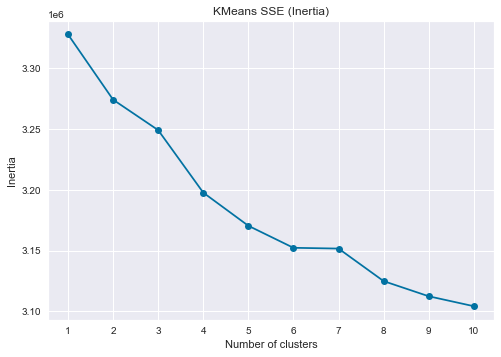

In [84]:
inertia = kmeans.elbow(clust_df, range(1, 11), 
                       plot = True, progress = True)

By fitting the model with $ K=1,\dots,10 $ clusters we can see how $ K = 4 $ may be an adequate choice.

Let's focus on $ K = 4 $ and explore the model we get.

In [85]:
model = kmeans.KMeans(K = 4)
model.fit(clust_df)

Our KMeans implementation with the default threshold of 0.005 took

In [86]:
model.n_iter

36

iterations to converge.

We can check the clustering we got by plotting the two main components obtained by PCA on the `echonest` dataset

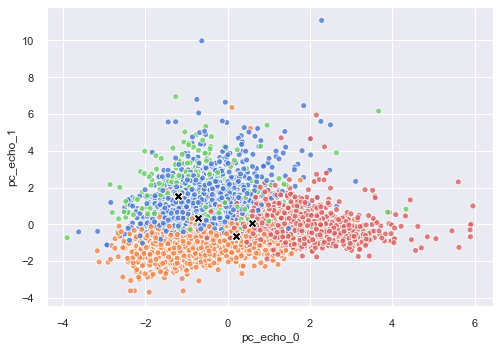

In [91]:
model.display(clust_df.iloc[:,-71], clust_df.iloc[:,-70], show_centroids = True)

We can immediately see how all points – regardless of the label they were given – are grouped together and overlay each other; this tells us that a 2D scatter plot is definitely not sufficient to appreciate how spread out the clusters actually are (and to confirm whether they are in fact well separated or not).

Same story if we look at the two main components out of the `features` dataset, although the separation is clearer here and the positions of the centroids actually reflect the regions of the different clusters, meaning that points of different clusters are somewhat more spread out than in the previous plot.

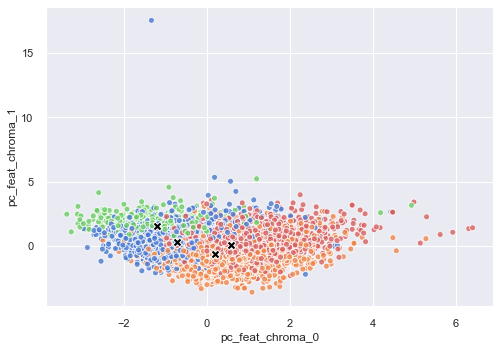

In [90]:
model.display(clust_df.iloc[:, 0], clust_df.iloc[:,1], show_centroids = True)

Let's perform a Silhouette analysis and see if we get any numeric confirmation of what these plots tell us.

The Silhouette score of a point ranges between -1 and 1, and is a measure of how well the point is "represented" by the cluster it was assigned to: a score of 1 indicates the point is very close to the center of the cluster it belongs in, and very far to all the other centers, with a score of -1 representing the exact opposite (implying the point was badly labelled); on the other hand, a score of 0 indicates the point sits on the boundary of two or more clusters, meaning that it could have been assigned equally well – or badly – to any of those.

By comparing each score to the overall average, we can assess how well the clusters were formed, and consequently how optimal was in fact the $ K $ we picked.

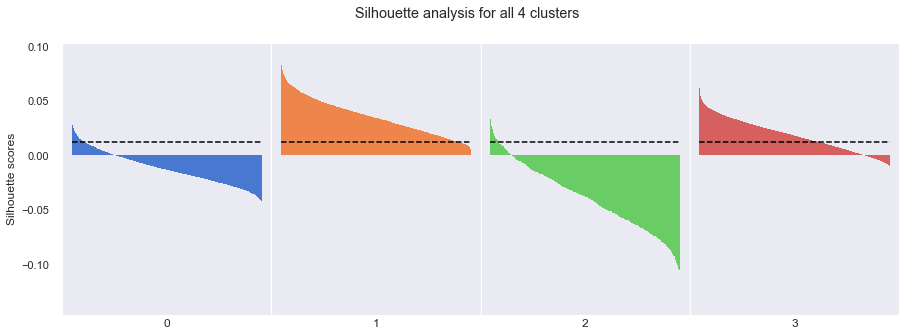

In [92]:
silh = model.silhouette(clust_df, plot = True, progress = True)

This plot describes what we preliminarly saw earlier: the Silhouette score is in fact very close to 0 for most points, meaning that there is no clear separation of the dataset in clusters.

This means that – even though the "orange" cluster looks to be much less representative of the points it's made of than the other three – many of the points of each cluster could have been assigned to any of the other clusters just by a different initialization of the centroids, still producing in the end an average score close to zero.

Average Silhouette score: 0.012


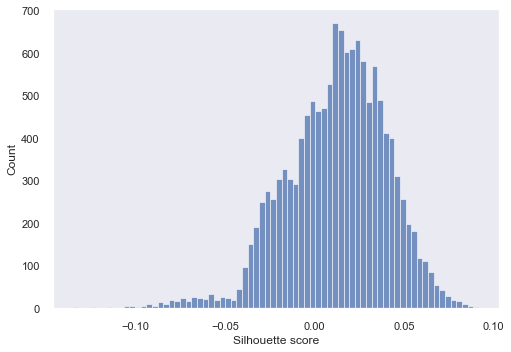

In [93]:
print(f"Average Silhouette score: {np.mean(silh):.3f}")

sns.histplot(silh)
plt.xlabel("Silhouette score")
plt.show()

In conclusion, we believe $K = 4$ is in fact a good choice, mainly due to the fact that no "bad" cluster was formed. 

The cluster overlay could have been mitigated by a different preprocessing / dimensionality-reduction method, but we are confident it is more than anything due to the intrinsically diverse and complex nature of the data.

Now that have we have a better grasp of the model obtained with our algorithm, let's see how it actually stacks up against scikit's implementation of `k-means++`, performance-wise and results-wise.

In [25]:
model_sk = KMeans(n_clusters = 4, init = "k-means++")
model_sk.fit(clust_df)
print(f"Converged in {model_sk.n_iter_} iterations")

Converged in 34 iterations


The difference in execution times is definitely very impressive: on a mid-range 2016 laptop, scikit's `k-means++` converged in just below 2 seconds, whereas our implementation took about 20.

Since the initialization of the centroids in our KMeans was random, the execution time will vary from run to run, but the difference was substantial in every test.

On the other hand, the results are definitely comparable.

The Silhouette score – which as expected was computed **much** faster – is

In [95]:
silhouette_score(clust_df, model_sk.fit_predict(clust_df))

0.010760290880559771

very close to the value our algorithm produced:

In [96]:
np.mean(silh)

0.012250674740932367

which suggests very similar clusters were formed.

Let's actually count how many out of the ~13000 total points were labelled differently.

First, we should make sure the labels are actually comparable; in order to do so, we can define a `new_labels` vector obtained by transforming every label in "scikit's" vector into its respective value in "our" vector.

In [101]:
print(f"Our labels       = {model.labels}")
print(f"scikit's labels  = {model_sk.labels_}")

new_labels = []

for lab in model_sk.labels_:
    if lab == 0:
        new_labels.append(0)
    elif lab == 1:
        new_labels.append(3)
    elif lab == 2:
        new_labels.append(1)
    elif lab == 3:
        new_labels.append(2)
        
new_labels = np.array(new_labels)

print(f"New scikit's     = {new_labels}")

Our labels       = [1 1 1 ... 3 0 0]
scikit's labels  = [2 2 2 ... 1 0 0]
New scikit's     = [1 1 1 ... 3 0 0]


What we get is that the vast majority of points were clustered the same way:

In [102]:
same_label_count = np.sum(model.labels == new_labels)
print(f"{same_label_count} / {len(clust_df.values)} share the same label")

12526 / 13129 share the same label


Just by taking a look again at the two main components of the `echonest` dataset and of the `features` dataset we do in fact get pretty much the same clusters.

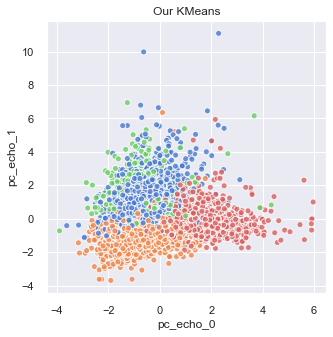

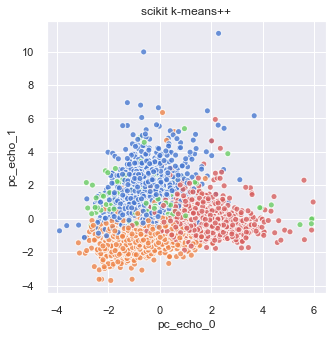

In [103]:
# two main components of 'echonest'
x = clust_df.iloc[:,-71]
y = clust_df.iloc[:,-70]

# our model
plt.figure(figsize = (5,5))
plt.title("Our KMeans")
model.display(x, y)
plt.show()

# sci-kit's model
plt.figure(figsize = (5,5))
plt.title("scikit k-means++")
plt.scatter(x, y, 
            edgecolors = "white", 
            alpha = 0.8, 
            color = [sns.color_palette("muted")[label]
                             for label in new_labels])
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.show()

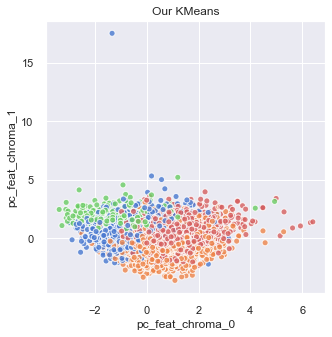

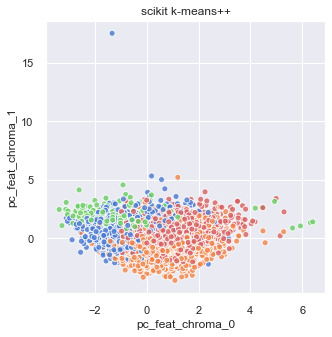

In [104]:
# two of the main components of 'features'
x = clust_df.iloc[:,0]
y = clust_df.iloc[:,1]

# our model
plt.figure(figsize = (5,5))
plt.title("Our KMeans")
model.display(x, y)
plt.show()

# sci-kit's model
plt.figure(figsize = (5,5))
plt.title("scikit k-means++")
plt.scatter(x, y, 
            edgecolors = "white", 
            alpha = 0.8, 
            color = [sns.color_palette("muted")[label]
                             for label in new_labels])
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.show()

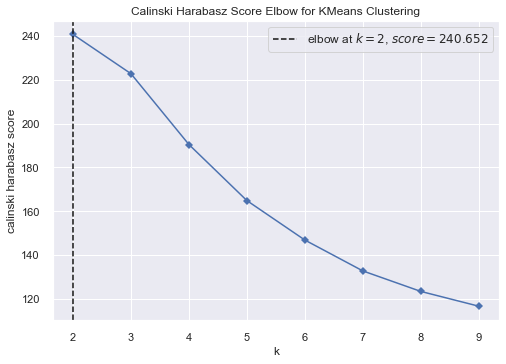

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [26]:
visualizer = KElbowVisualizer(model_sk, k=(2,10), metric="calinski_harabasz", timings=False)
visualizer.fit(clust_df)
visualizer.show()

## 2.4 Analysing your results!

In [107]:
clusters = model.labels
main_df_cp = main_df.copy()
main_df_cp.insert(1, "cluster", clusters)
main_df_cp.head()

,track_id,cluster,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,1,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,1,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,134,1,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,...,NaN,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music


In this part, it is required to select 5-10 variables, in order to build pivot tables and to identify the genre of a song.
So, we selected the following varables:
- *audio_features_acousticness*
- *audio_features_danceability*
- *audio_features_energy*
- *track_duration*
- *track_listens*
- *track_language_code*



Since there are some numeric variables, it is appropriate to categorize them in 4 classes, which will be $ 0\%-25\% $, $ 25\%-50\% $, $ 50\%-75\% $ and $ 75\%-100\% $, compare to their values.

In [137]:
def category(elem, class_):
    if elem <= class_[0]:
        return 'Category 1'
    elif class_[0] < elem <= class_[1]:
        return 'Category 2'
    elif class_[1] < elem <= class_[2]:
        return 'Category 3'
    else:
        return 'Category 4'


In [141]:
audio_acoust_des = list(main_df_cp.audio_features_acousticness.describe()[4:7])
audio_dance_des = list(main_df_cp.audio_features_danceability.describe()[4:7])
audio_ener_des = list(main_df_cp.audio_features_energy.describe()[4:7])
track_dur_des = list(main_df_cp.track_duration.describe()[4:7])
track_list_des = list(main_df_cp.track_listens.describe()[4:7])

In [142]:
audio_acoust_clus = main_df_cp.audio_features_acousticness.apply(lambda row: category(row, audio_acoust_des))
audio_dance_clus = main_df_cp.audio_features_danceability.apply(lambda row: category(row, audio_dance_des))
audio_ener_clus = main_df_cp.audio_features_energy.apply(lambda row: category(row, audio_ener_des))
track_dur_clus = main_df_cp.track_duration.apply(lambda row: category(row, track_dur_des))
track_list_clus = main_df_cp.track_listens.apply(lambda row: category(row, track_list_des))

In [208]:
print('Pivot table of audio_features_acousticness')
pivot_1 = pd.crosstab(index = audio_acoust_clus, columns = clusters,
            colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_1 = []
for i in range(4):
    total_1.append(sum(pivot_1[i]))

pivot_1.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_1.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_1.loc['Total'] = total_1
pivot_1

Pivot table of audio_features_acousticness


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Category 1,4.81,38.69,0.00,32.77
Category 2,15.66,36.36,0.71,25.99
Category 3,33.23,19.58,2.55,26.73
Category 4,46.30,5.37,96.75,14.50
Total,100.00,100.00,100.01,99.99


The pivot table of `audio_features_acousticness` seems not to be well balanced, and it is noticeable for the Cluster 3, where the "Category 1" has 0% and "Category 4" ~ 96%

In [209]:
print('Pivot table of audio_features_danceability')
pivot_2 = pd.crosstab(index = audio_dance_clus, columns = clusters,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_2 = []
for i in range(4):
    total_2.append(sum(pivot_2[i]))

pivot_2.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_2.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_2.loc['Total'] = total_2
pivot_2

Pivot table of audio_features_danceability


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Category 1,27.18,3.83,36.78,40.67
Category 2,29.75,12.06,36.92,31.07
Category 3,28.23,26.63,19.52,21.75
Category 4,14.85,57.48,6.79,6.52
Total,100.01,100.00,100.01,100.01


Also for this table, which contains the danceability of a song, the values are not well balanced, as we can see, some categories have values lower than 10%, and "Category 4" reaches in the second cluster, the value of ~ 57%, which is the highest in the table.

In [210]:
print('Pivot table of audio_features_energy')
pivot_3 = pd.crosstab(index = audio_ener_clus, columns = clusters,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_3 = []
for i in range(4):
    total_3.append(sum(pivot_3[i]))

pivot_3.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_3.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_3.loc['Total'] = total_3
pivot_3

Pivot table of audio_features_energy


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Category 1,57.41,10.31,88.54,2.32
Category 2,33.94,29.71,10.33,15.75
Category 3,7.79,34.24,1.13,34.22
Category 4,0.87,25.74,0.00,47.71
Total,100.01,100.00,100.00,100.00


It is noticeable in this table, that "Category 4" is not balanced at all, since for the first and third cluster its values do not reach even the 1%

In [211]:
print('Pivot table of track_duration')
pivot_4 = pd.crosstab(index = track_dur_clus, columns = clusters,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_4 = []
for i in range(4):
    total_4.append(sum(pivot_4[i]))

pivot_4.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_4.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_4.loc['Total'] = total_4
pivot_4

Pivot table of track_duration


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Category 1,18.09,24.92,33.38,29.69
Category 2,23.01,23.48,38.76,26.67
Category 3,25.26,27.43,16.12,23.26
Category 4,33.64,24.18,11.74,20.39
Total,100.00,100.01,100.00,100.01


The `track_duration` table seems to be the most balanced at this point: for cluster 2 and 4 the values are well balance, because are in a range between 20% and 30%.

In [212]:
print('Pivot table of track_listens')
pivot_5 = pd.crosstab(index = track_list_clus, columns = clusters,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_5 = []
for i in range(4):
    total_5.append(sum(pivot_5[i]))

pivot_5.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_5.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_5.loc['Total'] = total_5
pivot_5

Pivot table of track_listens


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Category 1,23.17,23.55,4.67,31.11
Category 2,24.82,24.90,13.30,27.04
Category 3,23.72,26.92,29.00,23.63
Category 4,28.29,24.63,53.04,18.22
Total,100.00,100.00,100.01,100.00


For this table, the first, the second and the fourth cluster are well balanced, but the third for "Category 1" has around 4% and for "Category 4" around 53%, this means the values are not balanced enough.

In [213]:
print('Pivot table of track_language_code')
pivot_6 = pd.crosstab(index = main_df_cp.track_language_code, columns = clusters,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_6 = []
for i in range(4):
    total_6.append(sum(pivot_6[i]))

pivot_6.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_6.index = list(pivot_6.index)
pivot_6.loc['Total'] = total_6
pivot_6

Pivot table of track_language_code


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
ar,0.24,0.06,0.00,0.00
bm,0.06,0.00,0.00,0.00
cs,0.00,0.00,0.00,0.09
de,0.06,0.00,0.00,0.14
el,0.00,0.00,0.00,0.23
en,96.88,93.50,99.75,96.02
es,0.82,3.22,0.25,2.20
fi,0.12,0.06,0.00,0.00
fr,0.18,1.01,0.00,0.09
it,0.29,0.44,0.00,0.05


This table highlights a common trend in music, which is the prevalence of songs written in english, which dominates each cluster.

## 2.4.6

In [ ]:
for col in main_df_cp.columns:
    if "genre" in str(col):
        print(col)

track_genre_top
track_genres
track_genres_all


In [ ]:
print('Pivot table of track_genre_top')
pivot_6 = pd.crosstab(index = main_df_cp.track_genre_top, columns = clusters,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_6 = []
for i in range(4):
    total_6.append(sum(pivot_6[i]))

pivot_6.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
pivot_6.index = list(pivot_6.index)
pivot_6.loc['Total'] = total_6
pivot_6

Pivot table of track_genre_top


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Blues,0.18,1.63,0.54,0.37
Classical,0.62,10.91,0.00,0.00
Electronic,23.74,11.00,10.93,49.24
Experimental,0.31,0.30,0.07,0.12
Folk,6.15,25.42,4.28,2.21
Hip-Hop,3.51,0.90,2.89,30.53
Instrumental,1.60,1.58,0.34,0.45
International,0.92,2.57,1.43,0.65
Jazz,2.15,6.63,1.29,0.53
Old-Time / Historic,0.31,14.81,0.00,0.25


The most representative genre for each cluster are:
* Cluster 1: Rock
* Cluster 2: Folk
* Cluster 3: Rock
* Cluster 4: Electronic

# 2.4.7

In [ ]:
# reduced using PCA
df_reduced = new_df_red.copy().select_dtypes(include = np.number).iloc[:,7:]
# standardize the data
cluster_df_reduced = pd.DataFrame(StandardScaler().fit_transform(df_reduced.values), columns = df_reduced.columns).fillna(value = 0)

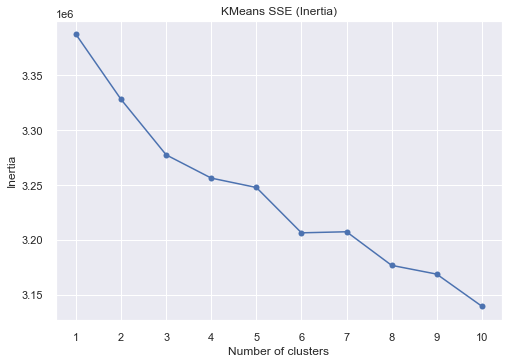

In [ ]:
# calculate optimal number of clusters (K=5)
inertia_reduced = kmeans.elbow(cluster_df_reduced, range(1, 11), plot = True, progress = True)

In [ ]:
#Kmenas++
model_sk_reduced = KMeans(n_clusters = 5, init = "k-means++")
model_sk_reduced.fit(cluster_df_reduced)
print(f"Converged in {model_sk_reduced.n_iter_} iterations")

Converged in 27 iterations


In [ ]:
silhouette_score(cluster_df_reduced, model_sk_reduced.fit_predict(cluster_df_reduced))

0.013076151510911377

Clustering

In [ ]:
clusters_reduced = model_sk_reduced.labels_
main_df_cp_reduced = pd.merge(features, tracks, on='track_id', how='inner')
main_df_cp_reduced.insert(1, "cluster", clusters)
main_df_cp_reduced.head()

,track_id,cluster,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,2,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,2,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,1,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,2,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [ ]:
track_interest_1 = list(main_df_cp_reduced.track_interest.describe()[4:7])
track_comments_1 = list(main_df_cp_reduced.track_comments.describe()[4:7])
track_favorites_1 = list(main_df_cp_reduced.track_favorites.describe()[4:7])
track_dur_des_1 = list(main_df_cp_reduced.track_duration.describe()[4:7])
track_list_des_1 = list(main_df_cp_reduced.track_listens.describe()[4:7])

In [ ]:
track_interest_clus_1 = main_df_cp_reduced.track_interest.apply(lambda row: category(row, track_interest_1))
track_comments_clus_1 = main_df_cp_reduced.track_comments.apply(lambda row: category(row, track_comments_1))
track_favorites_clus_1 = main_df_cp_reduced.track_favorites.apply(lambda row: category(row, track_favorites_1))
track_dur_clus_1 = main_df_cp_reduced.track_duration.apply(lambda row: category(row, track_dur_des_1))
track_list_clus_1 = main_df_cp_reduced.track_listens.apply(lambda row: category(row, track_list_des_1))

In [ ]:
print('Pivot table of track_interest (k-means++)')
pivot_1_ = pd.crosstab(index = track_interest_clus_1, columns = clusters_reduced,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_1_ = []
for i in range(5):
    total_1_.append(sum(pivot_1_[i]))

pivot_1_.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
pivot_1_.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_1_.loc['Total'] = total_1_
pivot_1_

Pivot table of track_interest (k-means++)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Category 1,23.50,19.64,0.0,31.15,25.21
Category 2,25.06,21.78,75.0,27.27,25.95
Category 3,25.62,25.46,0.0,23.87,25.09
Category 4,25.82,33.12,25.0,17.71,23.75
Total,100.00,100.00,100.0,100.00,100.00


In [ ]:
print('Pivot table of track_comments (k-means++)')
pivot_2_ = pd.crosstab(index = track_comments_clus_1, columns = clusters_reduced,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_2_ = []
for i in range(5):
    total_2_.append(sum(pivot_2_[i]))

pivot_2_.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
pivot_2_.index = ['Category 1', 'Category 2']
pivot_2_.loc['Total'] = total_2_
pivot_2_

Pivot table of track_comments (k-means++)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Category 1,97.86,97.5,100.0,98.27,98.39
Category 2,2.14,2.5,0.0,1.73,1.61
Total,100.00,100.0,100.0,100.00,100.00


In [ ]:
print('Pivot table of track_favorites (k-means++)')
pivot_3_ = pd.crosstab(index = track_favorites_clus_1, columns = clusters_reduced,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_3_ = []
for i in range(5):
    total_3_.append(sum(pivot_3_[i]))

pivot_3_.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
pivot_3_.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_3_.loc['Total'] = total_3_
pivot_3_

Pivot table of track_favorites (k-means++)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Category 1,38.38,33.27,75.0,44.80,41.03
Category 2,22.92,20.42,25.0,22.84,22.64
Category 3,18.95,19.35,0.0,17.63,18.49
Category 4,19.75,26.96,0.0,14.73,17.84
Total,100.00,100.00,100.0,100.00,100.00


In [ ]:
print('Pivot table of track_duration (k-means++)')
pivot_4_ = pd.crosstab(index = track_dur_clus_1, columns = clusters_reduced,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_4_ = []
for i in range(5):
    total_4_.append(sum(pivot_4_[i]))

pivot_4_.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
pivot_4_.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_4_.loc['Total'] = total_4_
pivot_4_

Pivot table of track_duration (k-means++)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Category 1,15.57,23.82,50.0,31.84,30.39
Category 2,23.68,24.73,25.0,28.28,22.13
Category 3,29.69,24.57,0.0,22.25,22.73
Category 4,31.05,26.88,25.0,17.64,24.74
Total,99.99,100.00,100.0,100.01,99.99


In [ ]:
print('Pivot table of track_listens (k-means++)')
pivot_5_ = pd.crosstab(index = track_list_clus_1, columns = clusters_reduced,
                      colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
total_5_ = []
for i in range(5):
    total_5_.append(sum(pivot_5_[i]))

pivot_5_.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
pivot_5_.index = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
pivot_5_.loc['Total'] = total_5_
pivot_5_

Pivot table of track_listens (k-means++)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Category 1,24.41,19.38,50.0,30.10,26.19
Category 2,24.76,21.67,25.0,28.02,25.10
Category 3,25.75,25.54,25.0,24.01,24.51
Category 4,25.08,33.42,0.0,17.87,24.20
Total,100.00,100.01,100.0,100.00,100.00


# 3. Algorithmic questions

You are given a list of integers, *A*, and another integer *s*. Write an algorithm that outputs all the pairs in *A* that equal *x*.

For example, if
```
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
```
the algorithm should output: `(7, -3), (-2, 6), (2, 2), (3, 1)`.

To solve this question, we have written 3 different algorithms, and we have compared them on the level of time complexity. Also, for this task, we thought to remove duplicates elements on the input list, which has a linear cost $ O(n) $.

## Brute Force
The time complexity of the algorithm below is $ O(n^{2}) $, because there are two `for` loops (nested `for`), which basically read all the elements of the list two times (the complexity of a `for` for a list is $ O(n) $, with $ n $ being the size of the input list).

In [58]:
def find_pairs_n_2(A, s):
    tup_list = []
    new_a = []
    for num in A:
        if num not in new_a: new_a.append(num)
    for i in range(len(new_a)-1):
        for j in range(i+1, len(new_a)):
            if new_a[i] + new_a[j] == s:
                tup = tuple((new_a[i], new_a[j]))
                tup_list.append(tup)
    return tup_list

## Sorting
The first algorithm is the worst for the complexity, so we need to find another one, and for this case, we wrote the one in the cell below, with time complexity equal to $ O(n \cdot log(n)) $, which sorts in ascending order the input list and uses two indices to search on the list the wanted numbers.

In [59]:
def find_pairs_n_logn(A, s):
    tup_list = []
    new_a = []
    for num in A:
        if num not in new_a: new_a.append(num)
    new_a.sort()
    start = 0
    end = len(new_a)-1
    while start < end:
        if new_a[start] + new_a[end] == s:
            tup_list.append((new_a[start], new_a[end]))
            start += 1
        elif new_a[start] + new_a[end] > s:
            end -= 1
        else:
            start += 1

    return tup_list

## Hashing
Even though the sorting algorithm is way better than the Brute-Force one, we thought that we could do better, so we wrote an algorithm using a hash table. So we used a dictionary to insert each element of the list in it, because the `in` checking has constant complexity ($ O(1) $), resulting in the final complexity of the algorithm as $ O(n) $, which at the end is the best so far.

In [60]:
def find_pairs_n(A, s):

    d = {}
    tup_list = []
    new_a = []
    for num in A:
        if num not in new_a: new_a.append(num)
    for i, e in enumerate(new_a):
        if s - e in d:
            tup_list.append((new_a[d.get(s - e)], new_a[i]))

        d[e] = i

    return tup_list

In [214]:
print('###################################')

for i in range(1, 6):
    n = i*10
    A = np.random.randint(-(n-i*3), n-i*2, n).tolist()
    s = n-2**i
    print("Lenght of the list:", n)
    print("A =", A)
    print("s =", s)

    pairs_n_2 = find_pairs_n_2(A, s)
    print(pairs_n_2)
    pairs_n_logn = find_pairs_n_logn(A, s)
    print(pairs_n_logn)
    pairs_n = find_pairs_n(A, s)
    print(pairs_n)
    %timeit find_pairs_n_2(A, s)
    %timeit find_pairs_n_logn(A, s)
    %timeit find_pairs_n(A, s)
    print('###################################')

###################################
Lenght of the list: 10
A = [7, 4, -3, 3, 4, -1, 3, 3, 7, -7]
s = 8
[]
[]
[]
1.81 µs ± 93.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.01 µs ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.02 µs ± 24.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
###################################
Lenght of the list: 20
A = [-5, -4, -7, 7, -5, 15, -13, -13, -7, -5, 1, -6, -8, -14, -9, -9, -12, -7, 14, -3]
s = 16
[(15, 1)]
[(1, 15)]
[(15, 1)]
6.17 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.46 µs ± 23 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.49 µs ± 72.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
###################################
Lenght of the list: 30
A = [9, -13, -7, 3, -10, -21, -18, 5, 11, -4, -9, 4, -1, 6, -2, 17, -19, 11, 10, 18, -21, 14, 19, -1, -8, 10, -1, -21, -15, -11]
s = 22
[(3, 19), (5, 17), (4, 18)]
[(3, 19), (4, 18), (5, 17)]
[(5,

As we can see from the results, the final time for the Hashing algorithm is the lowest for most of the configuration, as expected.